# 1. Imports

In [2]:
import numpy as np
import torch as t
import matplotlib.pyplot as plt

from feature_circuits.loading_utils import load_examples
from feature_circuits.attribution import patching_effect
from feature_circuits.activation_utils import SparseAct

from load_models import ModelLoader
from feature_selection import get_all_features, get_thres_features, get_top_features, get_topk_features, get_stratified_features, get_random_features
from feature_vis import transform_list, get_neuronpedia_quicklist

DEVICE = t.device("cuda" if t.cuda.is_available() else "cpu")

/home/aboehret/miniconda3/envs/sae/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/aboehret/miniconda3/envs/sae/lib/python3.11/site-packages/transformers/utils/hub.py:127: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


## Model and SAE

In [3]:
# Specify model and dictionary path
model_name = "EleutherAI/pythia-70m-deduped"
dictionary_path = "feature-circuits/dictionary_learning"

# Initialize the loader
loader = ModelLoader(model_name=model_name, dictionary_path=dictionary_path)

# Load the model, tokenizer, dictionaries, submodules, and names
model, tokenizer, dictionaries, submodules, submodule_names = loader.load_model()


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


## 2.1 Dataset

Example: 
- male_prefixes = "John runs because", male_answer = "he"
- female_prefixes = "Anna runs because", female_answer = "she"

In [4]:
num_examples = 50
length = 3

dataset_names = 'data/names.json'

examples_names = load_examples(dataset_names, num_examples, model, length=length)
m_inputs = t.cat([e['clean_prefix'] for e in examples_names], dim=0).to(DEVICE)
f_inputs = t.cat([e['patch_prefix'] for e in examples_names], dim=0).to(DEVICE)
m_answer_idxs = t.tensor([e['clean_answer'] for e in examples_names], dtype=t.long, device=DEVICE)
f_answer_idxs = t.tensor([e['patch_answer'] for e in examples_names], dtype=t.long, device=DEVICE)

# 3. Attribution patching

In [5]:
# Define metric - logit diff
def metric_fn(model, clean_answer_idxs, patch_answer_idxs):
    return (
        t.gather(model.embed_out.output[:,-1,:], dim=-1, index=patch_answer_idxs.view(-1, 1)).squeeze(-1) - \
        t.gather(model.embed_out.output[:,-1,:], dim=-1, index=clean_answer_idxs.view(-1, 1)).squeeze(-1)
    )


In [6]:
# clean_logit_diff
def run_clean_logit_diff(clean_prefixes, clean_answers, patch_answers):
    with t.no_grad(), model.trace(clean_prefixes):
        metric_values = metric_fn(model, clean_answers, patch_answers).save()
    return metric_values

## 3.1 Male Names

In [7]:
clean_male = run_clean_logit_diff(clean_prefixes=m_inputs, clean_answers=m_answer_idxs, patch_answers=f_answer_idxs)
print(clean_male.mean())

You're using a GPTNeoXTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


tensor(-1.9530, device='cuda:0')


In [8]:
male_effects = patching_effect(
        m_inputs,
        f_inputs,
        model,
        submodules,
        dictionaries,
        metric_fn = metric_fn,
        method = "ig",
        metric_kwargs={'clean_answer_idxs': m_answer_idxs, 'patch_answer_idxs': f_answer_idxs},
)

In [9]:
_, _, _, m_total = male_effects
print(m_total)
print('Mean Total Effect:', m_total.mean())

tensor([1.7327, 2.3501, 2.4655, 1.6837, 1.8619, 0.8065, 3.3904, 3.4794, 2.0775,
        2.1647, 1.5011, 2.0901, 0.2847, 0.9474, 3.4915, 2.3105, 3.5099, 1.4438,
        4.1980, 1.4552, 1.9852, 0.5535, 1.5405, 2.5065, 2.3644, 0.9592, 4.0538,
        4.0045, 1.8123, 2.7058, 2.9171, 1.0980, 2.3359, 2.7927, 2.2844, 2.0223,
        3.1919, 3.3861, 2.2045, 1.6444, 1.2972, 3.2065, 3.3591, 2.5847, 1.6901,
        1.7651, 2.6559, 1.6400, 2.1608, 2.8781], device='cuda:0')
Mean Total Effect: tensor(2.2569, device='cuda:0')


# 4. Feature Analysis and Interpretation

## 4.1 Feature Sampling

### 4.1.1 Male Names - All token Mean Effects

In [9]:
# Mean of features per submodule (over all examples and tokens)
def get_nodes(clean_effects, clean_inputs, submodules):
    nodes = None
    running_total = 0
    with t.no_grad():
        if nodes is None:
            # 50 * mean over all 3 tokens, mean over all 50 examples of value
            nodes = {k : len(clean_inputs) * v.sum(dim=1).mean(dim=0) for k, v in clean_effects.items()}
        else: # necessary if batches of data are used
            for k, v in clean_effects.items():
                nodes[k] += len(clean_inputs) * v.sum(dim=1).mean(dim=0)
        running_total += len(clean_inputs) # 50 examples
    # Necessary for batches
    nodes = {k : v / running_total for k, v in nodes.items()}
    
    return nodes

In [10]:
m_nodes = get_nodes(male_effects.effects, m_inputs, submodules)

all_nfeatures = get_all_features(m_nodes, submodule_names)
print(f"Total number of features with non-zero activation score: {sum(len(inner_dict) for inner_dict in all_nfeatures.values())}")

mn_thres = get_thres_features(m_nodes, submodule_names)
print(f"Total number of features with activation score above threshold: {sum(len(inner_dict) for inner_dict in mn_thres.values())}")
print(mn_thres)

top30 = get_topk_features(m_nodes, submodule_names=submodule_names, top_n=30)
# print(top30)

Total number of features with non-zero activation score: 43643
Total number of features with activation score above threshold: 19
{'attn_0': {31738: -0.1389819085597992}, 'attn_1': {}, 'attn_2': {27472: 0.49865493178367615}, 'attn_3': {2959: 0.303644597530365, 19128: 0.10656654089689255}, 'attn_4': {31101: 0.21799395978450775}, 'attn_5': {}, 'mlp_0': {}, 'mlp_1': {25018: 0.36824148893356323}, 'mlp_2': {}, 'mlp_3': {}, 'mlp_4': {}, 'mlp_5': {26689: -0.10129749029874802}, 'resid_0': {9651: 0.3808836340904236}, 'resid_1': {9877: 0.29394519329071045, 15963: 0.10944902151823044, 30248: 0.387736052274704}, 'resid_2': {1995: 0.1938902884721756, 29295: 0.3514541983604431}, 'resid_3': {19558: 0.5201192498207092, 27334: 0.24804769456386566}, 'resid_4': {12420: 0.708912193775177, 30220: 0.3863234221935272}, 'resid_5': {10643: 0.5425660014152527, 26074: 0.8665501475334167}}


In [14]:
rand_f = get_random_features(m_nodes, submodule_names, num_features=5, seed=12)
print(rand_f)

{'attn_0': {20008: -0.00011401664960430935}, 'attn_1': {9926: -0.0004049956041853875}, 'attn_2': {}, 'attn_3': {}, 'attn_4': {}, 'attn_5': {}, 'mlp_0': {}, 'mlp_1': {}, 'mlp_2': {}, 'mlp_3': {11829: -0.0005989535711705685}, 'mlp_4': {}, 'mlp_5': {17848: 9.03690579434624e-06}, 'resid_0': {}, 'resid_1': {}, 'resid_2': {}, 'resid_3': {}, 'resid_4': {27088: -2.895389116019942e-05}, 'resid_5': {}}


In [15]:
strat_f = get_stratified_features(m_nodes, submodule_names, num_features=15, seed=12)
print(strat_f)

{'attn_0': {2420: 0.0010717983823269606}, 'attn_1': {32674: 0.00013304185995366424}, 'attn_2': {10936: -1.3026296073803678e-05}, 'attn_3': {4203: -0.00021239205671008676, 9084: 2.3350878109340556e-05}, 'attn_4': {8019: -0.0001937416527653113}, 'attn_5': {}, 'mlp_0': {}, 'mlp_1': {}, 'mlp_2': {12737: -5.721845445805229e-05, 26547: -1.1699241440510377e-05}, 'mlp_3': {5705: -0.00017895510245580226, 32311: 0.0018657895270735025}, 'mlp_4': {}, 'mlp_5': {}, 'resid_0': {11471: 8.585296200180892e-06}, 'resid_1': {20136: -4.281113774595724e-07}, 'resid_2': {3199: 6.61211452097632e-05}, 'resid_3': {}, 'resid_4': {}, 'resid_5': {17857: -3.46255001204554e-05, 5496: 6.239862705115229e-05}}


In [16]:
# Initialize the merged dictionary
feature_set = {}

# Iterate over the keys (assuming all keys are overlapping)
for key in top30.keys():
    # Combine the inner dictionaries from both top30_tok and rand_tk
    feature_set[key] = {**top30[key], **rand_f[key], **strat_f[key]}

# Print the total count of features
print(f"Count Features: {sum(len(inner_dict) for inner_dict in feature_set.values())}")

Count Features: 50


### 4.1.2 Male Names - First Token Effects

In [16]:
# Mean of features per submodule (over all examples and tokens)
def get_effects_names_tokens(clean_effects, clean_inputs, submodules):
    nodes = None
    running_total = 0
    with t.no_grad():
        if nodes is None:
            # 50 * mean over all 3 tokens, mean over all 50 examples of value
            nodes = {k : SparseAct(v.mean(dim=0)[0]) for k, v in clean_effects.items()}
        else: # necessary if batches of data are used
            for k, v in clean_effects.items():
                nodes[k] += len(clean_inputs) * v.sum(dim=1).mean(dim=0)
    #     running_total += len(clean_inputs) # 50 examples
    # # Necessary for batches
    # nodes = {k : v / running_total for k, v in nodes.items()}
    
    return nodes

In [17]:
token_nodes = get_effects_names_tokens(male_effects.effects, m_inputs, submodules)

In [18]:
top30_tok = get_topk_features(token_nodes, submodule_names=submodule_names, top_n=30)
print(top30_tok)

{'attn_0': {31738: -0.08799760788679123, 29589: -0.06447534263134003, 25800: -0.05620381608605385, 19062: 0.055282339453697205, 2988: -0.04377911984920502, 15865: 0.043761324137449265}, 'attn_1': {}, 'attn_2': {27472: 0.14781256020069122}, 'attn_3': {}, 'attn_4': {}, 'attn_5': {}, 'mlp_0': {30328: 0.06522173434495926, 9566: 0.06346925348043442, 9133: 0.06281430274248123, 16856: 0.05552084371447563, 12600: 0.05176437273621559, 10258: 0.045222967863082886, 5761: 0.04479606822133064, 20080: 0.041422151029109955}, 'mlp_1': {25018: 0.36307281255722046}, 'mlp_2': {}, 'mlp_3': {}, 'mlp_4': {}, 'mlp_5': {}, 'resid_0': {9651: 0.3810223639011383, 7972: 0.08553116768598557, 2913: 0.07285953313112259, 5799: 0.06140368431806564, 4722: 0.05858733132481575, 19522: 0.05521298944950104, 19724: 0.05393730476498604, 20435: 0.048591990023851395}, 'resid_1': {30248: 0.387736052274704, 9877: 0.29394519329071045, 15963: 0.10944902151823044, 31152: 0.04590195417404175}, 'resid_2': {29295: 0.34573179483413696}

In [19]:
strat_tk = get_stratified_features(token_nodes, submodule_names, num_features=15, seed=12)
print(strat_tk)

{'attn_0': {10098: -1.4095980986894574e-05}, 'attn_1': {}, 'attn_2': {10237: 2.298166509717703e-05, 27229: 3.7015688576502725e-05}, 'attn_3': {}, 'attn_4': {}, 'attn_5': {}, 'mlp_0': {27350: 2.09550307772588e-05}, 'mlp_1': {5157: -0.00023400229110848159, 15254: -8.018280823307578e-06}, 'mlp_2': {31515: -3.0580944439861923e-05}, 'mlp_3': {7180: 4.040632120450027e-06, 5798: 2.0622868760256097e-05}, 'mlp_4': {}, 'mlp_5': {}, 'resid_0': {27959: -3.244101753807627e-05, 24414: 5.7555345847504213e-05, 7529: 0.00044629379408434033}, 'resid_1': {25893: -0.00021540607849601656, 4418: 0.0005377361085265875}, 'resid_2': {10757: 0.0033654391299933195}, 'resid_3': {}, 'resid_4': {}, 'resid_5': {}}


In [20]:
rand_tk = get_random_features(token_nodes, submodule_names, num_features=6, seed=12)
print(rand_tk)

{'attn_0': {}, 'attn_1': {1805: -1.244662371391314e-06}, 'attn_2': {13441: 0.0002394276816630736}, 'attn_3': {}, 'attn_4': {}, 'attn_5': {}, 'mlp_0': {}, 'mlp_1': {}, 'mlp_2': {}, 'mlp_3': {19069: 2.8222810215083882e-05}, 'mlp_4': {}, 'mlp_5': {}, 'resid_0': {}, 'resid_1': {13834: -8.232865366153419e-05}, 'resid_2': {11404: 0.0009940162999555469}, 'resid_3': {31453: 0.044196967035532}, 'resid_4': {}, 'resid_5': {}}


In [21]:
# Initialize the merged dictionary
feature_set_tok = {}

# Iterate over the keys (assuming all keys are overlapping)
for key in top30_tok.keys():
    # Combine the inner dictionaries from both top30_tok and rand_tk
    feature_set_tok[key] = {**top30_tok[key], **rand_tk[key], **strat_tk[key]}

# Print the total count of features
print(f"Count Features: {sum(len(inner_dict) for inner_dict in feature_set_tok.values())}")

Count Features: 50


## 4.2 Visualisation via Neuronpedia

In [22]:
feature_set_total = transform_list(feature_set, 'pythia-70m-deduped')
get_neuronpedia_quicklist(feature_set_total)

Opening: https://neuronpedia.org/quick-list/?name=Gender%20features&features=%5B%7B%22modelId%22%3A%20%22pythia-70m-deduped%22%2C%20%22layer%22%3A%20%220-att-sm%22%2C%20%22index%22%3A%20%2231738%22%7D%2C%20%7B%22modelId%22%3A%20%22pythia-70m-deduped%22%2C%20%22layer%22%3A%20%220-att-sm%22%2C%20%22index%22%3A%20%2225800%22%7D%2C%20%7B%22modelId%22%3A%20%22pythia-70m-deduped%22%2C%20%22layer%22%3A%20%220-att-sm%22%2C%20%22index%22%3A%20%222988%22%7D%2C%20%7B%22modelId%22%3A%20%22pythia-70m-deduped%22%2C%20%22layer%22%3A%20%220-att-sm%22%2C%20%22index%22%3A%20%2219062%22%7D%2C%20%7B%22modelId%22%3A%20%22pythia-70m-deduped%22%2C%20%22layer%22%3A%20%220-att-sm%22%2C%20%22index%22%3A%20%2220008%22%7D%2C%20%7B%22modelId%22%3A%20%22pythia-70m-deduped%22%2C%20%22layer%22%3A%20%220-att-sm%22%2C%20%22index%22%3A%20%222420%22%7D%2C%20%7B%22modelId%22%3A%20%22pythia-70m-deduped%22%2C%20%22layer%22%3A%20%221-att-sm%22%2C%20%22index%22%3A%20%229926%22%7D%2C%20%7B%22modelId%22%3A%20%22pythia-70m-dedup

In [23]:
feature_set_token = transform_list(feature_set_tok, 'pythia-70m-deduped')
get_neuronpedia_quicklist(feature_set_token)

Opening: https://neuronpedia.org/quick-list/?name=Gender%20features&features=%5B%7B%22modelId%22%3A%20%22pythia-70m-deduped%22%2C%20%22layer%22%3A%20%220-att-sm%22%2C%20%22index%22%3A%20%2231738%22%7D%2C%20%7B%22modelId%22%3A%20%22pythia-70m-deduped%22%2C%20%22layer%22%3A%20%220-att-sm%22%2C%20%22index%22%3A%20%2229589%22%7D%2C%20%7B%22modelId%22%3A%20%22pythia-70m-deduped%22%2C%20%22layer%22%3A%20%220-att-sm%22%2C%20%22index%22%3A%20%2225800%22%7D%2C%20%7B%22modelId%22%3A%20%22pythia-70m-deduped%22%2C%20%22layer%22%3A%20%220-att-sm%22%2C%20%22index%22%3A%20%2219062%22%7D%2C%20%7B%22modelId%22%3A%20%22pythia-70m-deduped%22%2C%20%22layer%22%3A%20%220-att-sm%22%2C%20%22index%22%3A%20%222988%22%7D%2C%20%7B%22modelId%22%3A%20%22pythia-70m-deduped%22%2C%20%22layer%22%3A%20%220-att-sm%22%2C%20%22index%22%3A%20%2215865%22%7D%2C%20%7B%22modelId%22%3A%20%22pythia-70m-deduped%22%2C%20%22layer%22%3A%20%220-att-sm%22%2C%20%22index%22%3A%20%2210098%22%7D%2C%20%7B%22modelId%22%3A%20%22pythia-70m-ded

#### Interpretation

**Top 30 clean = male features:**
NOT = not considered gender
XX = look again, overlapping concepts
AMB = consider to show as ambiguous features

        [{'modelId': 'pythia-70m-deduped', 'layer': '5-res-sm', 'index': '26074'}, FP
        {'modelId': 'pythia-70m-deduped', 'layer': '5-res-sm', 'index': '10643'}, MP
        {'modelId': 'pythia-70m-deduped', 'layer': '5-res-sm', 'index': '31975'}, FW
        {'modelId': 'pythia-70m-deduped', 'layer': '4-res-sm', 'index': '12420'}, FP
        {'modelId': 'pythia-70m-deduped', 'layer': '4-res-sm', 'index': '30220'}, MP
        {'modelId': 'pythia-70m-deduped', 'layer': '3-res-sm', 'index': '19558'}, FP
        {'modelId': 'pythia-70m-deduped', 'layer': '3-res-sm', 'index': '27334'}, MP
        {'modelId': 'pythia-70m-deduped', 'layer': '2-att-sm', 'index': '27472'}, FP
        {'modelId': 'pythia-70m-deduped', 'layer': '1-res-sm', 'index': '30248'}, end FN
        {'modelId': 'pythia-70m-deduped', 'layer': '1-res-sm', 'index': '9877'}, FN
        {'modelId': 'pythia-70m-deduped', 'layer': '1-res-sm', 'index': '15963'}, FN
        {'modelId': 'pythia-70m-deduped', 'layer': '0-res-sm', 'index': '9651'}, FN
        {'modelId': 'pythia-70m-deduped', 'layer': '0-res-sm', 'index': '7972'}, FN
        {'modelId': 'pythia-70m-deduped', 'layer': '0-res-sm', 'index': '2913'}, FN
        {'modelId': 'pythia-70m-deduped', 'layer': '0-res-sm', 'index': '19522'}, MN token NOT
        {'modelId': 'pythia-70m-deduped', 'layer': '1-mlp-sm', 'index': '25018'}, end FN
        {'modelId': 'pythia-70m-deduped', 'layer': '2-res-sm', 'index': '29295'}, FP end FN XX
        {'modelId': 'pythia-70m-deduped', 'layer': '2-res-sm', 'index': '1995'}, FP + FW
        {'modelId': 'pythia-70m-deduped', 'layer': '3-att-sm', 'index': '2959'}, FP (AMB?)
        {'modelId': 'pythia-70m-deduped', 'layer': '3-att-sm', 'index': '19128'}, MP
        {'modelId': 'pythia-70m-deduped', 'layer': '4-att-sm', 'index': '31101'}, FP
        {'modelId': 'pythia-70m-deduped', 'layer': '0-att-sm', 'index': '31738'}, MN NOT
    X   {'modelId': 'pythia-70m-deduped', 'layer': '0-att-sm', 'index': '25800'}, NOT
    X   {'modelId': 'pythia-70m-deduped', 'layer': '0-att-sm', 'index': '2988'}, NOT
    X   {'modelId': 'pythia-70m-deduped', 'layer': '0-att-sm', 'index': '19062'}, NOT
        {'modelId': 'pythia-70m-deduped', 'layer': '5-mlp-sm', 'index': '26689'}, MAYBE !!!!
    X   {'modelId': 'pythia-70m-deduped', 'layer': '5-mlp-sm', 'index': '27658'}, NOT
    X   {'modelId': 'pythia-70m-deduped', 'layer': '0-mlp-sm', 'index': '30328'}, FN AMB
        {'modelId': 'pythia-70m-deduped', 'layer': '0-mlp-sm', 'index': '9566'}, FN AMB
    X   {'modelId': 'pythia-70m-deduped', 'layer': '0-mlp-sm', 'index': '9133'}] FN AMB

------

# Plots for Male Names

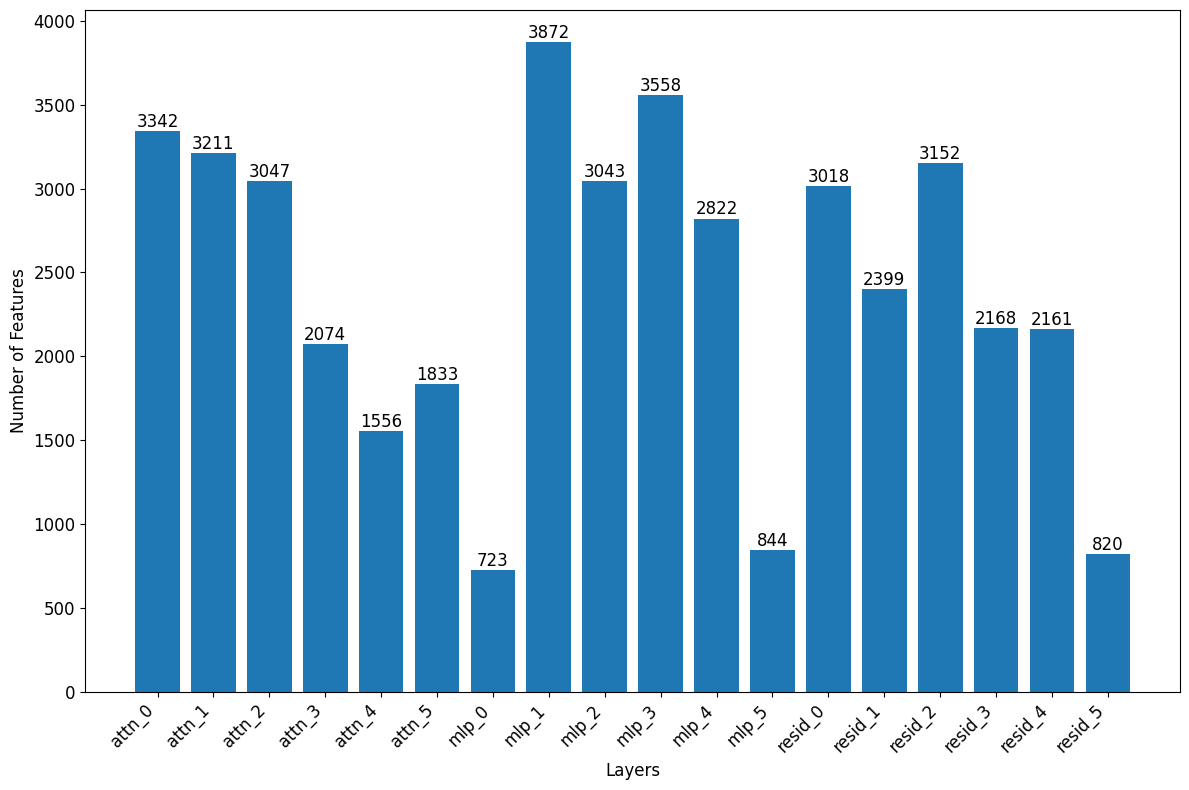

In [22]:
# Count the number of features in each submodule
all_feature_counts = [len(features) for features in all_nfeatures.values()]
submodule_names_all = [key for key in all_nfeatures.keys()]

# Create a histogram plot
plt.figure(figsize=(12, 8))
bars = plt.bar(submodule_names_all, all_feature_counts)

# Add values on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.2, int(yval), ha='center', va='bottom', fontsize=12)

# Labeling the plot
plt.xlabel('Layers', fontsize=12)
plt.ylabel('Number of Features', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)

# Save the plot
plt.savefig("./figures/counts_per_layer.png", dpi=300, bbox_inches='tight')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


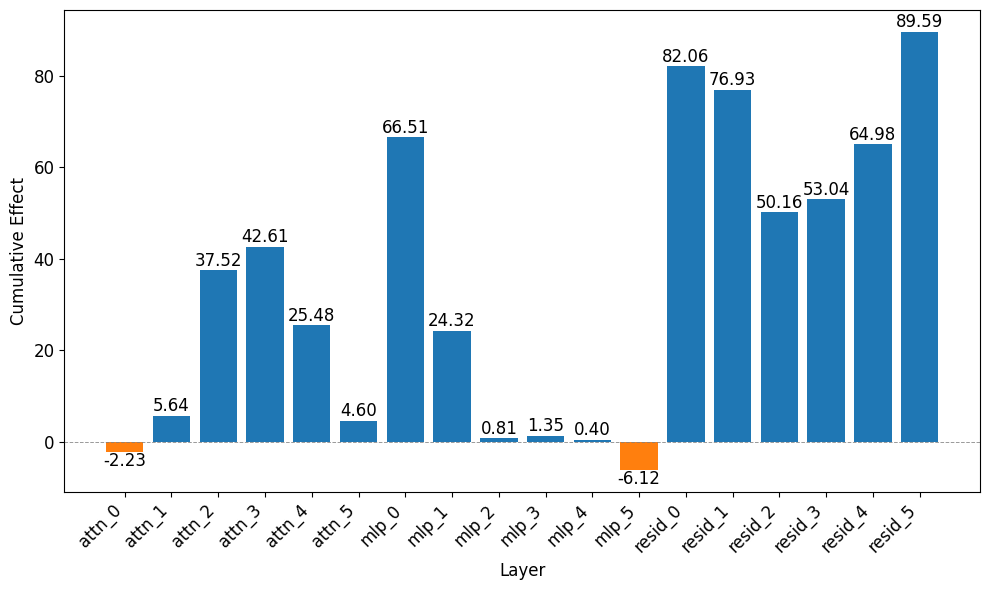

In [22]:
# Cumulative effects
cumulative_effects = {}

# Loop through each layer in the effects dictionary
for layer, effect_tensor in male_effects.effects.items():
    # Get the non-zero effects
    non_zero_effects = effect_tensor[effect_tensor != 0]  # Filter non-zero elements
    # Sum the non-zero effects to get the cumulative effect for the layer
    # cumulative_effects[submodule_names[layer]] = t.abs(non_zero_effects).sum().item()
    cumulative_effects[submodule_names[layer]] = non_zero_effects.sum().item()

# Now plot the cumulative effects per layer
layers = list(cumulative_effects.keys())
cumulative_values = list(cumulative_effects.values())

# Convert cumulative_values to a NumPy array for easier manipulation
cumulative_values_np = np.array(cumulative_values)

# Define color scheme: positive values will be 'blue', negative will be 'orange'
colors = np.where(cumulative_values_np < 0, '#ff7f0e', '#1f77b4')

# Plotting
plt.figure(figsize=(10, 6))
bars = plt.bar(layers, cumulative_values_np, color=colors)

# Add zero line
plt.axhline(0, color='gray', linestyle='--', linewidth=0.7, alpha=0.8)

# Labeling axes and improving aesthetics
plt.xlabel('Layer', fontsize=12)
plt.ylabel('Cumulative Effect', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)

# Highlight negative bars with annotations (optional)
for bar, value in zip(bars, cumulative_values_np):
    if value < 0:
        plt.text(bar.get_x() + bar.get_width()/2, value - 0.1, f'{value:.2f}', 
                 ha='center',  color='black', va='top', fontsize=12)
    else:
        plt.text(bar.get_x() + bar.get_width()/2, value + 0.1, f'{value:.2f}', 
                 ha='center', va='bottom', color='black', fontsize=12)

# Save the plot
plt.savefig("./figures/cumulative_effects.png", dpi=300, bbox_inches='tight')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


In [15]:
# Heat Maps Data
effect_tuples = []
for submodule in submodules:
    feature_effects = male_effects.effects[submodule].mean(dim=(0, 1))
    for i, effect in enumerate(feature_effects):
        effect_tuples.append((submodule, submodule_names[submodule], i, effect.item()))

example_prompt = [(0, '[Name]'), (1, '[verb]'), (2, 'because')]
clean_prefixes_tokenized = ['[Name]', '[verb]', 'because']
attns = submodules[0:6]
mlps =  submodules[6:12]
resids = submodules[12:18]

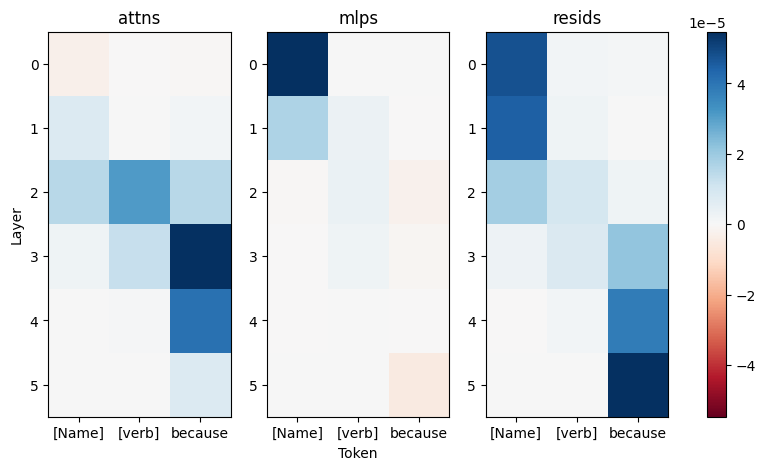

In [16]:
# Define submodules for plotting
submodule_types = ['attns', 'mlps', 'resids']
fig, axes = plt.subplots(1, 3, figsize=(10, 5))  # 3 subplots in a row

for ax, submodule_type in zip(axes, submodule_types):
    feature_effects = []
    for submodule in globals()[submodule_type]:
        effs = male_effects.effects[submodule].act.mean(dim=(0, 2)).cpu().detach().numpy()
        feature_effects.append(effs)

    # Display the feature effects
    im = ax.imshow(feature_effects, aspect='auto', cmap='RdBu')

    # Create a colorbar
    max_val = max([abs(eff).max() for eff in feature_effects])
    im.set_clim(-max_val, max_val)

    # Set subplot title
    ax.set_title(f'{submodule_type}')

    # Set axis labels
    
    xticklabels = [f"{i}: {prompt}" for i, prompt in example_prompt]
    ax.set_xticks(range(len(clean_prefixes_tokenized)), clean_prefixes_tokenized)#, rotation=90)
axes[1].set_xlabel('Token')
axes[0].set_ylabel('Layer')
# fig.suptitle('Mean feature effects by position and layer')

# Create a colorbar for all subplots
fig.colorbar(im, ax=axes.ravel().tolist())

# Save the plot
plt.savefig("./figures/attention_maps.png", dpi=300, bbox_inches='tight')

plt.show()
